### Pseudo code
- List all instances of iteration
--- entry1 = [5, 4, 3, 2, 1]
--- entry2 = [10, 20]
--- filter1 = [7, 8, 9, 10, 11]
--- filter2 = [30, 40, 50, 60, 70]
--- exit1 = [5, 4, 3, 2, 1]
--- exit2 = [10, 20]

- Expand data1 
--- entry1 -> [HH5, HH4, HH3, HH2, HH1]
--- outcome -> expanded data1 with multiple colummn

- Generate train and test
--- data1 --> train and test

- Iterate to create list of input_dict on train
                            input_dict = {
                                'enter' : enter_augcp,
                                'exit' : exit_cp,
                                'stoploss_needed' : stoploss_needed,
                                'sell_buy_gap' : sell_buy_gap,
                                'entry_name' : entry_name,
                                'filter_name' : filter_name,
                                'exit_name' : exit_name
                            }
- Use fitness function to find the best combo for train input_dict



In [1]:
# end=None
algo_file = './data/algo.csv'

In [2]:
import math
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf 
import talib as TA
from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta
#
from pyfinance import TSeries
import ffn
#
from findiff import FinDiff
from scipy.signal import find_peaks
from scipy import stats
import pywt
#
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
#
from various_trading_algo import peak_trough_projection_no_leaking, peak_trough_calculus_projection_no_leaking
from various_trading_algo import peak_trough_projection_cwt, peak_trough_projection_relextrema
from various_trading_algo import peak_trough_projection_pywt
from various_trading_algo import strategy, strategy_stoploss1, strategy_stoploss, annualised_sharpe
from various_trading_algo import get_max_drawdown
from various_trading_algo import ohlc_gen
from various_trading_algo import get_kpi_run_strategy
#
from generic_peak_trough_algo import generic_peak_trough_projection_pywt
#
import crossover_trading_algo
#
import finta
import math
import os.path
#
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

In [19]:
def peak(df,duration):
    peak1=df.rolling(window=duration).max() 
    return(peak1)

#### Entry grid is dynamically composed

In [20]:
def generate_algocase_list(entry_grid, data_buy, stop_list, gap_list):
    algocase_list = list()
    for entry_exit_var_set in entry_grid:
        entry1_val = tuple(entry_exit_var_set)[0]
        filter1_val = tuple(entry_exit_var_set)[1]
        # print(list(entry_exit_var_set))
        entry_dict = {
            'cross_over_up_highestclose' : crossover_trading_algo.cross_over_level,
        }
        entry_params_dict = {
            'cross_over_up_highestclose' : (data_buy,"Close","HClose{}".format(entry1_val),"H2Close{}".format(entry1_val)),
        }
        filter_dict = {
            'filter_ADX_trend_only' : crossover_trading_algo.filter_2_threshold,
        }
        filter_param_dict = {
            'filter_ADX_trend_only' : (data_buy,'ADX','trend_ADX',filter1_val,0)
        }
        exit_dict = {
            'progressive_stoploss' : None,
        }
        exit_params_dict = {
            'progressive_stoploss' : None,
        }
        #
        for entry_name, entry_func in entry_dict.items():
            enter_cp = entry_func(entry_params_dict[entry_name])
            for filter_name, filter_func in filter_dict.items():
                augm_cp = filter_func(filter_param_dict[filter_name])
                for exit_name, exit_func in exit_dict.items():
                    if exit_func is None:
                        exit_cp = None
                    else:
                        exit_cp = exit_func(exit_params_dict[exit_name])
                    enter_augcp = (enter_cp==1) & augm_cp
                    #
                    for stoploss_needed in stop_list:
                        if (exit_cp is np.nan) & (not stoploss_needed):
                            pass
                        else:
                            for sell_buy_gap in gap_list:
                                other = list(entry_exit_var_set) + [stoploss_needed,sell_buy_gap]
                                # print(other)
                                input_dict = {
                                    'enter' : enter_augcp,
                                    'exit' : exit_cp,
                                    'stoploss_needed' : stoploss_needed,
                                    'sell_buy_gap' : sell_buy_gap,
                                    'entry_name' : entry_name,
                                    'filter_name' : filter_name,
                                    'exit_name' : exit_name,
                                    ### dynamic
                                    'other' : tuple(other),
                                }
                                algocase_list.append(input_dict)
    return algocase_list

# Backtesting

In [21]:
def gen_cond_dict(L1, algocase_instance):
    cond_dict = {
        'stock': L1
    }
    criteria_list = ['entry_name', 'filter_name', 'exit_name', 'stoploss_needed', 'sell_buy_gap']
    for k in criteria_list:
        cond_dict[k] = algocase_instance[k]
    return cond_dict

def check_algo_notexist(cond_dict, algokpi_df):
    criteria_series = None
    for key, val in cond_dict.items():
        cond = algokpi_df[key] == val
        if criteria_series is None:
            criteria_series = cond
        else:
            criteria_series = criteria_series & cond
    return algokpi_df[criteria_series].shape[0]==0

### Compare each algorithm

In [22]:
start_time = datetime.now()
#
# read algo csv
algohist_df = pd.read_csv(algo_file)
algohist_df.set_index('index', drop=True, inplace=True)

In [23]:
algohist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40320 entries, 0 to 40319
Data columns (total 34 columns):
stock                   40320 non-null object
entry_name              40320 non-null object
filter_name             40320 non-null object
exit_name               40320 non-null object
sell_buy_gap            40320 non-null int64
avg_drawdown_days       39224 non-null float64
end_equity_curve        40320 non-null float64
max_drawdown            40320 non-null float64
stoploss_needed         40320 non-null bool
daily_sharpe            40113 non-null float64
calmar                  38042 non-null float64
profit_factor           40113 non-null float64
start_price             40320 non-null float64
equity_curve            40320 non-null object
trade_qty               40320 non-null int64
r_squared               40320 non-null float64
yearly_return_std       40320 non-null float64
max_dd_duration         39224 non-null float64
cagr                    38249 non-null float64
win_over_l

In [24]:
top_index = 17379
algohist_df.iloc[top_index]

stock                                                             2020.HK
entry_name                                 cross_over_up_tushar_chande_MA
filter_name                                       filter_cutome_EMA_ADX_1
exit_name                                       cross_over_down_prevclose
sell_buy_gap                                                            1
avg_drawdown_days                                                     287
end_equity_curve                                                -0.240001
max_drawdown                                                          2.1
stoploss_needed                                                     False
daily_sharpe                                                  7.65147e-05
calmar                                                         -0.0119533
profit_factor                                                    0.951904
start_price                                                         10.54
equity_curve            index\n2008-01

### List of Instances

In [25]:
stock_code = '2318.HK'
data_csv = stock_code[:4] + '_2008_2018.csv'
read_allow = True
# L1="^HSI"
start='2009-01-01'
end='2018-12-31'
entry1_iter = [5, 4, 3, 2] # Highest close in the last X days 
filter1_iter = [20,21,22,25,30]
# exit1_iter = [7, 10, 13, 17, 21]
# exit2_iter = [2.5, 3.0, 3.5]
sell_buy_gap_choices = [1, 5, 10]
stop_loss_list = [True,False]

### Expand data1

In [26]:
data_csv = stock_code[:4] + '_2008_2018.csv'
data, ohlc_col = ohlc_gen(stock_code,data_csv,_,_,read_allow)
#

Reading ./data/2318_2008_2018.csv


### Create new col for data1

In [27]:
'''
'cross_over_down_ATR21' : (data_buy,"Low","trailing_ATR_{}_{}".format(exit1_val,exit2_val)),
data['ATR21'] = TA.ATR(data['High'],data['Low'],data['Close'],timeperiod=21)
data['prevATR21'] = data['ATR21'].shift(1)
data['trailing_ATR'] = data['prevClose'] - 3*data['prevATR21']  
exit1_iter = [7, 10, 13, 17, 21]
exit2_iter = [2.5, 3.0, 3.5]
'''

for k in entry1_iter:
    new_col = 'HClose{}'.format(k)
    new_col1 = 'H2Close{}'.format(k)
    data[new_col] = data['Close'].rolling(k).max()
    data[new_col1] = data['Close'].rolling(k).apply(lambda x: pd.Series(x).nlargest(2).iloc[-1])
'''
for k in exit1_iter:
    new_col = 'ATR{}'.format(k)
    data[new_col] = TA.ATR(data['High'],data['Low'],data['Close'],timeperiod=k)
    for l in exit2_iter:
        new_col2 = "trailing_ATR_{}_{}".format(k,l)
        data[new_col2] = data['prevClose'] - l * data[new_col].shift(1)

'''

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


'\nfor k in exit1_iter:\n    new_col = \'ATR{}\'.format(k)\n    data[new_col] = TA.ATR(data[\'High\'],data[\'Low\'],data[\'Close\'],timeperiod=k)\n    for l in exit2_iter:\n        new_col2 = "trailing_ATR_{}_{}".format(k,l)\n        data[new_col2] = data[\'prevClose\'] - l * data[new_col].shift(1)\n\n'

### Generate Train and Test

In [28]:
train_month = 48
test_month = 12
#
test_start = data.index[0]
start_year = data.index[0].year
start_month = data.index[0].month
print(start_year, start_month)
if start_month != 1:
    start_year = start_year + 1
    start_month = 1
#
# start_year = 2009
# start_month = 1
#    
train_start = datetime.strptime('{}-{}-1'.format(start_year,start_month), '%Y-%m-%d')
train_end = train_start + relativedelta(months=train_month) + relativedelta(days=-1)
print(train_start, train_end)

2007 1
2007-01-01 00:00:00 2010-12-31 00:00:00


In [29]:
data_train = data.loc[train_start:train_end]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 985 entries, 2007-01-03 to 2010-12-30
Columns: 102 entries, Open to H2Close2
dtypes: bool(13), datetime64[ns](1), float64(83), int64(4), object(1)
memory usage: 705.1+ KB


### Iterate to create list of input_dict on train

In [30]:
# entry1_val = entry1_iter[0] # Highest close in the last X days 
# filter1_val = filter1_iter[0]

In [31]:
# Dynamic
entry_grid = [(x,y) for x in entry1_iter \
              for y in filter1_iter]

# entry_grid = [set([x]) for x in filter1_iter]

In [32]:
# data_train = train_start : train_end + buffer
algocase_list = generate_algocase_list(entry_grid, data_train, stop_loss_list, sell_buy_gap_choices)
print('Number of cases {}'.format(len(algocase_list)))

Number of cases 120


In [33]:
algocase_list

[{'enter': 2007-01-03    False
  2007-01-04    False
  2007-01-05    False
  2007-01-08    False
  2007-01-09    False
  2007-01-10    False
  2007-01-11    False
  2007-01-12    False
  2007-01-15    False
  2007-01-16    False
  2007-01-17    False
  2007-01-18    False
  2007-01-19    False
  2007-01-22    False
  2007-01-23    False
  2007-01-24    False
  2007-01-25    False
  2007-01-26    False
  2007-01-29    False
  2007-01-30    False
  2007-01-31    False
  2007-02-01    False
  2007-02-02    False
  2007-02-05    False
  2007-02-06    False
  2007-02-07    False
  2007-02-08    False
  2007-02-09    False
  2007-02-12    False
  2007-02-13    False
                ...  
  2010-11-17    False
  2010-11-18    False
  2010-11-19    False
  2010-11-22    False
  2010-11-23    False
  2010-11-24    False
  2010-11-25    False
  2010-11-26    False
  2010-11-29    False
  2010-11-30    False
  2010-12-01    False
  2010-12-02    False
  2010-12-03    False
  2010-12-06    False
 

In [34]:
algokpi_list = list()
#
if len(algocase_list) > 0:
    parallel = True
    if parallel:
        cpu = cpu_count()
        # cpu = 4
        print('cpu_count {}'.format(cpu))
        executor = Parallel(n_jobs=cpu, backend='multiprocessing')
        tasks = (delayed(get_kpi_run_strategy)(stock_code, data_train, input_dict) for input_dict in algocase_list)
        algokpi_list.extend(executor(tasks))
    else:
        for input_dict in algocase_list:
            print(input_dict)
            algokpi_list.append(get_kpi_run_strategy(stock_code, data_train, input_dict))

cpu_count 4


/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:451: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exceed_dates = df.loc[prog_date:][df['Close']> next_target].index
/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:451: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exceed_dates = df.loc[prog_date:][df['Close']> next_target].index
/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:451: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exceed_dates = df.loc[prog_date:][df['Close']> next_target].index
/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:451: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exceed_dates = df.loc[prog_date:][df['Close']> next_target].index
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy

In [35]:
algokpi_df = pd.DataFrame(algokpi_list)
first_col = ['stock','entry_name','filter_name','exit_name','sell_buy_gap','avg_drawdown_days','end_equity_curve']
second_col = list(set(algokpi_df.columns.to_list())-set(first_col))
algokpi_df = algokpi_df[first_col+second_col]
algokpi_df.head(10)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
0,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,425.333333,-2.1775,True,0.294696,2.203816,...,-0.849602,0.041150,0.300214,47,1.583333,32,-3.670833,24.8275,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
1,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,5,603.500000,0.9725,True,0.051832,2.045469,...,-0.576899,0.021359,0.235096,47,1.777778,26,-3.528333,15.9325,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
2,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,603.500000,3.7125,True,0.006199,2.088500,...,-0.477686,0.018089,0.307941,47,1.875000,24,-3.451875,13.1925,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
3,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,425.333333,-2.1775,False,0.294696,2.203816,...,-0.849602,0.041150,0.300214,47,1.583333,32,-3.670833,24.8275,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
4,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,5,603.500000,0.9725,False,0.051832,2.045469,...,-0.576899,0.021359,0.235096,47,1.777778,26,-3.528333,15.9325,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
5,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,603.500000,3.7125,False,0.006199,2.088500,...,-0.477686,0.018089,0.307941,47,1.875000,24,-3.451875,13.1925,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
6,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,425.333333,-5.9325,True,0.525829,2.242206,...,-0.908375,-0.436130,0.324245,47,1.416667,30,-3.670833,26.5450,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
7,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,5,603.500000,-2.7825,True,0.398981,2.069464,...,-0.639088,-0.226373,0.116184,47,1.555556,24,-3.528333,17.6500,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
8,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,603.500000,-0.0425,True,0.227545,2.120962,...,-0.539875,-0.191717,0.184390,47,1.625000,22,-3.451875,14.9100,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999
9,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,425.333333,-5.9325,False,0.525829,2.242206,...,-0.908375,-0.436130,0.324245,47,1.416667,30,-3.670833,26.5450,index 2007-01-03 0.0000 2007-01-04 0.000...,23.924999


In [36]:
algokpi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 32 columns):
stock                   120 non-null object
entry_name              120 non-null object
filter_name             120 non-null object
exit_name               120 non-null object
sell_buy_gap            120 non-null int64
avg_drawdown_days       120 non-null float64
end_equity_curve        120 non-null float64
stoploss_needed         120 non-null bool
r_squared               120 non-null float64
win_average             120 non-null float64
CAGR/MDD                120 non-null float64
yearly_return_std       120 non-null float64
total_return            120 non-null float64
combo                   120 non-null float64
threshold               120 non-null float64
other                   120 non-null object
yearly_sharpe           120 non-null float64
cagr                    120 non-null float64
calmar                  120 non-null float64
k_ratio                 120 non-null float64
max_d

In [37]:
algokpi_df.sort_values(by='r_squared',ascending=False).head(3)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
96,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,True,0.931675,2.752951,...,-0.191191,0.1563,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
99,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,False,0.931675,2.752951,...,-0.191191,0.1563,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
105,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.607875,False,0.931660,2.752951,...,-0.191191,0.1563,0.904364,47,3.833333,30,-3.618333,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999


In [38]:
algokpi_df.sort_values(by='cagr',ascending=False).head(3)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
108,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,106.0,43.000375,True,0.889831,3.101204,...,-0.168285,0.112838,1.045179,47,4.750000,23,-3.980625,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
111,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,106.0,43.000375,False,0.889831,3.101204,...,-0.168285,0.112838,1.045179,47,4.750000,23,-3.980625,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
99,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,False,0.931675,2.752951,...,-0.191191,0.156300,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999


In [39]:
algokpi_df.sort_values(by='combo',ascending=False).head(3)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
96,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,True,0.931675,2.752951,...,-0.191191,0.1563,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
99,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,False,0.931675,2.752951,...,-0.191191,0.1563,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
105,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.607875,False,0.931660,2.752951,...,-0.191191,0.1563,0.904364,47,3.833333,30,-3.618333,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999


In [40]:
col = ['entry_name','filter_name','exit_name','max_drawdown_percent']
algokpi_df[col].sort_values(by='max_drawdown_percent',ascending=True).head(3)

,entry_name,filter_name,exit_name,max_drawdown_percent
6,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,-0.908375
9,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,-0.908375
15,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,-0.899778


### Sorted by K-ratio

In [41]:
algokpi_df.sort_values(by='k_ratio', ascending=False).head(5)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
99,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,False,0.931675,2.752951,...,-0.191191,0.156300,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
96,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.610375,True,0.931675,2.752951,...,-0.191191,0.156300,0.904391,47,3.833333,30,-3.617917,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
102,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.607875,True,0.931660,2.752951,...,-0.191191,0.156300,0.904364,47,3.833333,30,-3.618333,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
105,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,99.6,41.607875,False,0.931660,2.752951,...,-0.191191,0.156300,0.904364,47,3.833333,30,-3.618333,6.8475,index 2007-01-03 0.000000 2007-01-04 0...,23.924999
90,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,1,110.6,40.448350,True,0.930004,2.615434,...,-0.191191,0.169055,0.888372,47,3.571429,33,-3.562500,6.8475,index 2007-01-03 0.00000 2007-01-04 0....,23.924999


### Sorted by CAR/MDD ratio

In [42]:
algokpi_df.sort_values(by='CAGR/MDD',ascending=False).head(3)

,stock,entry_name,filter_name,exit_name,sell_buy_gap,avg_drawdown_days,end_equity_curve,stoploss_needed,r_squared,win_average,...,max_drawdown_percent,yearly_return_median,daily_sharpe,month_qty,win_over_loss_count,trade_qty,loss_average,max_drawdown,equity_curve,start_price
110,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,143.0,39.076250,True,0.817345,3.292946,...,-0.083285,0.080315,1.002625,47,7.0,16,-3.5125,3.5750,index 2007-01-03 0.00000 2007-01-04 0....,23.924999
113,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,143.0,39.076250,False,0.817345,3.292946,...,-0.083285,0.080315,1.002625,47,7.0,16,-3.5125,3.5750,index 2007-01-03 0.00000 2007-01-04 0....,23.924999
62,2318.HK,cross_over_up_highestclose,filter_ADX_trend_only,progressive_stoploss,10,150.0,37.646949,True,0.799689,2.545450,...,-0.124569,0.088865,0.907832,47,4.2,27,-3.1615,6.3875,index 2007-01-03 0.000000 2007-01-04 0...,23.924999


### Sorted by combo factor

In [43]:
col = ['trade_qty', 'max_dd_duration', 'k_ratio', 'CAGR/MDD']
algokpi_df[col].describe()

,trade_qty,max_dd_duration,k_ratio,CAGR/MDD
count,120.000000,120.000000,120.000000,120.000000
mean,22.500000,328.516667,27.294878,0.939082
std,6.191618,298.091097,44.201238,1.025925
min,11.000000,1.000000,-39.747975,-0.108524
25%,17.750000,16.000000,-11.989412,0.029059
50%,23.000000,279.000000,17.731584,0.547333
75%,27.000000,676.000000,68.360686,1.879288
max,34.000000,684.000000,115.775717,4.281465


In [53]:
threshold = 0.85
k_thres = algokpi_df['k_ratio'].quantile(threshold)
c_thres = algokpi_df['CAGR/MDD'].quantile(threshold)
algocond = algokpi_df[(algokpi_df['k_ratio']>k_thres) & (algokpi_df['CAGR/MDD']>c_thres)]

In [54]:
algocond.shape[0]

4

### Top performer

In [55]:
#
# top_index = algokpi_df.loc[condition].sort_values(by='k_ratio', ascending=False).index[0]
top_index = algocond.sort_values(by='cagr',ascending=False).index[0]
algokpi_df.loc[top_index]

stock                                                             2318.HK
entry_name                                     cross_over_up_highestclose
filter_name                                         filter_ADX_trend_only
exit_name                                            progressive_stoploss
sell_buy_gap                                                            1
avg_drawdown_days                                                     106
end_equity_curve                                                  43.0004
stoploss_needed                                                      True
r_squared                                                        0.889831
win_average                                                        3.1012
CAGR/MDD                                                           2.2581
yearly_return_std                                               0.0761075
total_return                                                        2.614
combo                                 

### Optimized Set

In [57]:
best_list = algokpi_df.loc[top_index, 'other']
entry1_best = best_list[0]
filter1_best = best_list[1]
stop_loss_best = best_list[2]
gap_best = best_list[3]
equity_train = algokpi_df.loc[top_index, 'equity_curve']

In [58]:
best_list

[2, 25, True, 1]

### Test

In [59]:
test_start = train_end + relativedelta(days=1)
test_end = train_end + relativedelta(months=test_month)
print(test_start, test_end)

2011-01-01 00:00:00 2011-12-31 00:00:00


In [60]:
data_test = data.loc[test_start:test_end]

#### Dynamic change

In [61]:
entry_grid = [(entry1_best, filter1_best)]
entry_grid

[(2, 25)]

In [62]:
algocase_list = generate_algocase_list(entry_grid, data_test, [stop_loss_best], [gap_best])
print('Number of cases {}'.format(len(algocase_list)))

Number of cases 1


In [63]:
algo_test = get_kpi_run_strategy(stock_code, data_test, algocase_list[0])
equity_test = algo_test['equity_curve']
algo_test

/home/keithyamkf/jupyter-notebook/python-trading/backtesting/various_trading_algo.py:451: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exceed_dates = df.loc[prog_date:][df['Close']> next_target].index
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


{'stock': '2318.HK',
 'stoploss_needed': True,
 'entry_name': 'cross_over_up_highestclose',
 'filter_name': 'filter_ADX_trend_only',
 'exit_name': 'progressive_stoploss',
 'sell_buy_gap': 1,
 'threshold': 0.9,
 'end_equity_curve': -4.868749809265136,
 'start_price': 44.150001525878906,
 'trade_qty': 5,
 'month_qty': 11,
 'profit_factor': 0.4184831414753577,
 'calmar': -0.6403963160284069,
 'win_over_loss_count': 0.6666666666666666,
 'win_average': 1.751875019073486,
 'loss_average': -2.7908332824707025,
 'total_return': -0.12404458112777428,
 'daily_sharpe': -0.9160294453980247,
 'cagr': -0.1254093045276059,
 'max_drawdown': 8.372499847412108,
 'max_dd_duration': 40,
 'max_drawdown_percent': -0.19583077133448556,
 'avg_drawdown_days': 107.0,
 'yearly_return_median': nan,
 'yearly_return_std': nan,
 'yearly_sharpe': nan,
 'r_squared': 0.3723342440478452,
 'other': [2, 25, True, 1],
 'combo': -0.04669417859785215,
 'k_ratio': -11.956685170021133,
 'equity_curve': index
 2011-01-03    0.0

In [64]:
col = ['Close','ADX','prevADX']
data_test.loc['2013-1-1':'2013-2-28', col]

,Close,ADX,prevADX
index,,,


### Plot Graph

In [65]:
equity_train

index
2007-01-03     0.000000
2007-01-04     0.000000
2007-01-05     0.000000
2007-01-08     0.000000
2007-01-09     0.000000
2007-01-10     0.000000
2007-01-11     0.000000
2007-01-12     0.000000
2007-01-15     0.000000
2007-01-16     0.000000
2007-01-17     0.000000
2007-01-18     0.000000
2007-01-19     0.000000
2007-01-22     0.000000
2007-01-23     0.000000
2007-01-24     0.000000
2007-01-25     0.000000
2007-01-26     0.000000
2007-01-29     0.000000
2007-01-30     0.000000
2007-01-31     0.000000
2007-02-01     0.000000
2007-02-02     0.000000
2007-02-05     0.000000
2007-02-06     0.000000
2007-02-07     0.000000
2007-02-08     0.000000
2007-02-09     0.000000
2007-02-12     0.000000
2007-02-13     0.000000
                ...    
2010-11-17    43.000375
2010-11-18    43.000375
2010-11-19    43.000375
2010-11-22    43.000375
2010-11-23    43.000375
2010-11-24    43.000375
2010-11-25    43.000375
2010-11-26    43.000375
2010-11-29    43.000375
2010-11-30    43.000375
2010-12-01

/opt/miniconda3/envs/conda_env/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


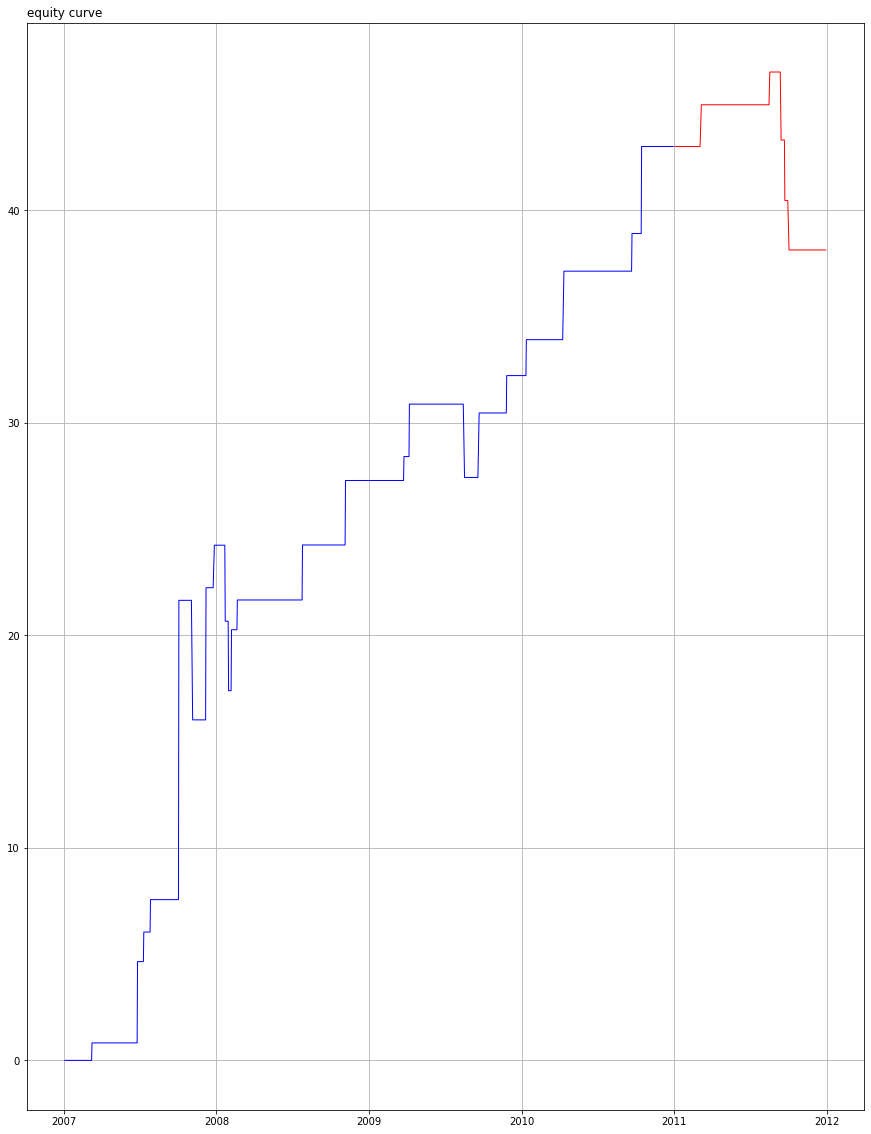

In [66]:
offset = equity_train[-1]

fig = plt.figure(figsize = (15,20))
plt.title('equity curve', loc='left')
#
plt.plot(equity_train.index,equity_train.values,color="blue",label="train",linewidth=1)
plt.plot(equity_test.index,(equity_test+offset).values,color="red",label="test",linewidth=1)
plt.grid(True)

### Study Equity Curve

In [67]:
equity_1 = equity_test.copy()
diff = np.pad(np.where(np.diff(equity_1)!=0.0,equity_1[1:],0),(1,0),"constant")
diff1 =pd.Series(diff,index=list(equity_1.index))
diff1[diff1!=0].loc['2013-1-1':'2013-12-31']

Series([], dtype: float64)